# The Game of Life and Artificial Life

We mentioned in Lecture 1 that the inner workings of an organism form complex systems at multiple scales, and a collection of interacting and evolving organisms also form a complex system.

In fact, the biological world is full of overlapping layers of complexity that it is difficult to derive deep understanding. In particular, it is very difficult to answer the question, "what is life?"

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/dd/Langtonsmall2.png">
    <figcaption>Christopher Langton</figcaption>
</figure>

In the mid-1980s, Christopher Langton proposed to study "life-as-it-<em>could</em>-be", instead of "life-as-we-know-it". He believes that different combinations of the fundamental organizing principles of life can produce not only the biological organisms that we see in our ecosystem, but is also capable of producing lifeforms and ecosystems that we have yet to encounter.

By thinking of life this way, we can then ask the question of whether all the known organizing principles of life are necessary, or could there be a minimal subset of organizing principles that are more fundamental than others.

# John Conway's Game of Life

In 1970, British mathematician John Conway invented a zero-player game called the <em>Game of Life</em>.

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/John_H_Conway_2005_%28cropped%29.jpg/500px-John_H_Conway_2005_%28cropped%29.jpg">
    <figcaption>John Conway</figcaption>
</figure>

The Game of Life is an example of a <em>cellular automata</em>, which is a discrete model of computation. Typically, we play this game on a square grid with $N \times N$ cells.

Each cell can only have two possible states, <em>dead</em> (represented by a '0', and the cell left empty (white)) or <em>alive</em> (represented by a '1', and the cell is colored black).

A live cell can remain alive, or die in the next time step, while a dead cell can remain dead, or come to life in the next time step, depending on its neighborhood of eight cells (north, northeast, east, southeast, south, southwest, west, northwes).

## Rules

The rules for the Game of Life's time evolution are simple:
<ol>
    <li> If a live cell is surrounded by fewer than two live neighbours, it dies because of underpopulation;
    <li> If a live cell is surrounded by two or three live neighbours, it remains alive;
    <li> If a live cell is surrounded by more than three live neighbours, it dies because of overpopulation;
    <li> If a dead cell is surrounded by exactly three live neighbours, it comes to live in the next turn.
</ol>
        

# Programming the Game of Life in Python

Because of the simply rules, the Game of Life is easy to programme.

Let us do this step by step in Python.

First, for running numeric simulations, it is convenient to import the NumPy module in Python, as:

In [48]:
# import modules
import numpy as np

We should also import the PyPlot module, for plotting our results.

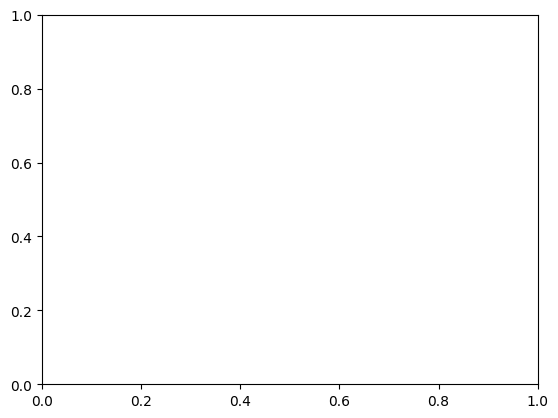

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

Next, let us specify $N$, the size of the board as:

In [50]:
# specify size of board
N = 50

Following this, let us create the game board as a NumPy array:

In [51]:
# create game board
board = np.zeros((N,N))

This game board consists initially of all zeros, i.e., all dead cells. Therefore, the next thing to do is to specify the initial configuration of live cells on the board.

In [52]:
# initialize game board
for i in range(N):
    for j in range(N):
        if np.random.rand() < 0.2:
            board[i,j] = 1.0

In [53]:
im = ax.matshow(board)
ims = []
ims.append([im])

You can specify any initial configuration of live cells you like here. Here let us try a random initial configuration, where 20% of the cells are alive, and the remaining dead. We can also work with a lower or higher proportions, but these would lead to underpopulation and overpopulation, and the whole board may just die out in the next time step.

Let us take a look at the board we created.

In [54]:
# plt.matshow(board)

Let us start by running the simulation one step at a time. To do this, we need to loop over cells on the board, and store the results in a new game board.

But before we can do this, we have to first solve a subtle problem: if I am a cell along the edge of the board, or at the corner of the board, who are my neighbors?

There are many ways to handle this.

One way would be to treat the corners and edges of the board to be special, in that they have fewer neighbours. However, if we do this, we would also have to modify the conditions for such cells to remain alive or dead.

Another way to handle this would be to imagine that the parallel edges of the game board wrapping around to join together. In this way, the eastern neighbour of a cell on the eastern edge of the board is a cell on the western edge of the board, while the northern neighbour of a cell on the northern edge of the board is a cell on the southern edge of the board.

In this second way to handle neighbours, called <em>periodic boundary conditions</em>, we do not need to modify the conditions for living and dead cells, because all cells have the same number (8) of neighbours.

Whatever boundary conditions we wish to implement, it is useful to create a data structure called a <em>neighbour list</em>. This can be done using a dictionary as follows:

In [55]:
# initialize dictionary
nbrs = dict()
# neighbors of corners
nbrs[(0,0)] = [ (0, 1), (1, 1), (1, 0) ]
nbrs[(0,N-1)] = [ (1, N-1), (1, N-2), (0, N-2) ]
nbrs[(N-1,N-1)] = [ (N-1, N-2), (N-2, N-2), (N-2, N-1) ]
nbrs[(N-1,0)] = [ (N-2, 0), (N-2, 1), (N-1, 1) ]
# neighbors of left edge
for j in range(1,N-1):
    nbrs[(0,j)] = [ (0, j+1), (1, j+1), (1, j), (1, j-1), (0, j-1) ]
# neighbors of top edge
for i in range(1,N-1):
    nbrs[(i,N-1)] = [ (i+1, N-1), (i+1, N-2), (i, N-2), (i-1, N-2), (i-1, N-1) ]
# neighbors of right edge
for j in range(1,N-1):
    nbrs[(N-1,j)] =  [ (N-1, j-1), (N-2, j-1), (N-2, j), (N-2, j+1), (N-1, j+1) ]
# neighbors of bottom edge
for i in range(1,N-1):
    nbrs[(i,0)] = [ (i-1, 0), (i-1, 1), (i, 1), (i+1, 1), (i+1, 0) ]
# neighbors of interior nodes
for i in range(1,N-1):
    for j in range(1,N-1):
        nbrs[(i,j)] = [ (i, j+1), (i+1, j+1), (i+1, j), (i+1, j-1), (i, j-1), (i-1, j-1), (i-1, j), (i-1, j+1) ]

In [56]:
nbrs[(0,0)]

[(0, 1), (1, 1), (1, 0)]

We can now simulate one turn of the Game of Life as follows:

In [72]:
def step_(board,N):
  # create new game board to store results
  newboard = np.zeros((N,N))
  # loop over all cells on the board
  for i in range(N):
      for j in range(N):
          # initialize number of neighbors
          numnbr = 0
          # loop over neighbors
          for (k,l) in nbrs[(i,j)]:
              numnbr += board[k,l]
          # update board[i,j] to newboard[i,j]
          if board[i,j] == 1.0:
              if (numnbr < 2.0) or (numnbr > 3.0):
                  newboard[i,j] = 0.0
              else:
                  newboard[i,j] = 1.0
          else:
              if numnbr == 3.0:
                  newboard[i,j] = 1.0
              else:
                  newboard[i,j] = 0.0
  board = np.array(newboard)
  return board
board = step_(board,N)
im = ax.matshow(board,animated=True)
ims.append([im])

Let us take a look at the updated board.

In [58]:
# plt.matshow(board)

Next, we specify the total number of turns $T$ that we would like to simulate:

In [59]:
# specify number of turns to simulate
T = 50

Finally, we run the simulation for $T = 20$ time steps.

In [60]:
for t in range(T):
    board = step_(board,N)
    im = ax.matshow(board,animated=True)
    ims.append([im])

Let us now see after simulating the Game of Life for 20 turns, what board we end up with.

In [61]:
import matplotlib.animation as animation

In [62]:
# plt.matshow(board)

In [63]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

In [64]:
# show ani
ani.save('gameoflife.gif', writer='imagemagick', fps=60)

## Periodic Boundary Conditions

In the above example, we simulated the Game of Life using fixed boundary conditions, i.e., the grid ends at the four boundaries and do not extend beyond.

We can also simulate the Game of Life using periodic boundary conditions.

How do you adapt the <code>nbrs</code> array for this to happen?

In [90]:
class PeriodicNBRS:
  def __init__(self, N,p=0.2):
    self.fig, self.ax = plt.subplots()
    self.ims = []
    self.N = N
    self.board = np.zeros((N,N))

    # initialize game board
    for i in range(N):
        for j in range(N):
            if np.random.rand() < p:
                self.board[i,j] = 1.0

    im = self.ax.matshow(board,animated=True)
    self.ims.append([im])

  def init_nbrs_periodic(self):
    N = self.N
    # initialize dictionary
    nbrs = dict()
    # neighbors of corners
    nbrs[(0,0)] = [ (0, 1), (1, 1), (1, 0) ] + [(0,N-1), (N-1,N-1), (N-1,0)]
    nbrs[(0,N-1)] = [ (1, N-1), (1, N-2), (0, N-2) ] + [(0,0), (N-1,N-1), (N-1,0)]
    nbrs[(N-1,N-1)] = [ (N-1, N-2), (N-2, N-2), (N-2, N-1) ] + [(0,0), (0,N-1), (N-1,0)]
    nbrs[(N-1,0)] = [ (N-2, 0), (N-2, 1), (N-1, 1) ] + [(0,0), (0,N-1), (N-1,N-1)]
    # neighbors of left edge
    for j in range(1,N-1):
        nbrs[(0,j)] = [ (0, j+1), (1, j+1), (1, j), (1, j-1), (0, j-1) ]
        nbrs[(0,j)].extend([(N-1,j+1), (N-1, j), (N-1, j-1)])
    # neighbors of top edge
    for i in range(1,N-1):
        nbrs[(i,N-1)] = [ (i+1, N-1), (i+1, N-2), (i, N-2), (i-1, N-2), (i-1, N-1) ]
        nbrs[(i,N-1)].extend([(i+1, 0), (i, 0), (i-1, 0)])
    # neighbors of right edge
    for j in range(1,N-1):
        nbrs[(N-1,j)] =  [ (N-1, j-1), (N-2, j-1), (N-2, j), (N-2, j+1), (N-1, j+1) ]
        nbrs[(N-1,j)].extend([(0, j-1), (0, j), (0, j+1)])
    # neighbors of bottom edge
    for i in range(1,N-1):
        nbrs[(i,0)] = [ (i-1, 0), (i-1, 1), (i, 1), (i+1, 1), (i+1, 0) ]
        nbrs[(i,0)].extend([(i-1, N-1), (i, N-1), (i+1, N-1)])
    # neighbors of interior nodes
    for i in range(1,N-1):
        for j in range(1,N-1):
            nbrs[(i,j)] = [ (i, j+1), (i+1, j+1), (i+1, j), (i+1, j-1), (i, j-1), (i-1, j-1), (i-1, j), (i-1, j+1) ]
    self.nbrs = nbrs
    return self.nbrs

  def step(self):
    # create new game board to store results
    newboard = np.zeros((N,N))
    # loop over all cells on the board
    for i in range(N):
        for j in range(N):
            # initialize number of neighbors
            numnbr = 0
            # loop over neighbors
            for (k,l) in nbrs[(i,j)]:
                numnbr += self.board[k,l]
            # update board[i,j] to newboard[i,j]
            if self.board[i,j] == 1.0:
                if (numnbr < 2.0) or (numnbr > 3.0):
                    newboard[i,j] = 0.0
                else:
                    newboard[i,j] = 1.0
            else:
                if numnbr == 3.0:
                    newboard[i,j] = 1.0
                else:
                    newboard[i,j] = 0.0
    self.board = np.array(newboard)
    im = self.ax.matshow(self.board,animated=True)
    self.ims.append([im])
    return self.board

  def show(self,Name='gameoflife_periodic.gif'):
    ani = animation.ArtistAnimation(self.fig, self.ims, interval=50, blit=True,
                                    repeat_delay=1000)
    # show ani
    ani.save(Name, writer='imagemagick', fps=60)

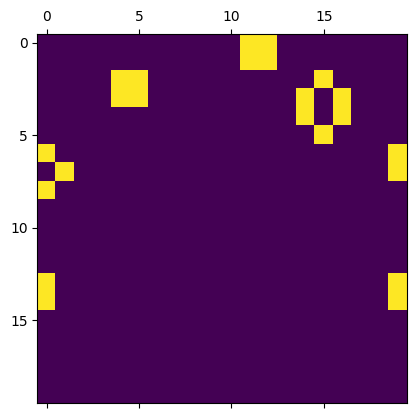

In [91]:
N = 20
T = 100
PNBRS = PeriodicNBRS(N)
PNBRS.init_nbrs_periodic()
for t in range(T):
    PNBRS.step()
PNBRS.show()

## Gliders and Breeders

Go to the Wikipedia page <a href="https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life">Game of Life</a> on the Game of Life, to check that the patterns given indeed behave as they are described.

## Test Your Own Patterns

Design also some of your own patterns, to see if they would survive in the Game of Life simulation.